# Configure project paths

In [1]:
import sys

def config_paths(user, env_name):
    paths = ['',
             '/home/{0}/{1}/.env/bin'.format(user, env_name),
             '/usr/lib/python35.zip',
             '/usr/lib/python3.5',
             '/usr/lib/python3.5/plat-x86_64-linux-gnu',
             '/usr/lib/python3.5/lib-dynload',
             '/home/{0}/{1}/.env/lib/python3.5/site-packages'.format(user, env_name),
             '/home/{0}/{1}/.env/lib/python3.5/site-packages/IPython/extensions'.format(user, env_name),
             '/home/{0}/.ipython']

    for path in paths:
        sys.path.append(path)
        
config_paths('omri', 'my_gpu')


# Load Libraries

In [2]:
from os import listdir
import os
from skimage.io import imread, imshow
import numpy as np
from tqdm import tqdm_notebook
from skimage.transform import resize
import time
import pandas as pd

from keras.models import Model
from keras import metrics
from keras.layers import Input, Flatten
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

/home/omri/my_gpu/.env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Images

In [3]:
path = '../' # Path relative to the notebook
labels = range(128) + np.ones(128)

In [4]:
def read_chunk(chunk_size, chunk_number, labels):
    imgs = []
    imgs_labels = []
    for i in tqdm_notebook(labels, total=len(labels)):
        label_path = os.path.join(path, str(int(i)))
        files = listdir(label_path)
#         for file in tqdm_notebook(files[chunk_number*chunk_size:chunk_number*chunk_size + chunk_size], total=chunk_size):
        for file in files[chunk_number*chunk_size:chunk_number*chunk_size + chunk_size]:
            filepath = os.path.join(label_path, file)
            imgs.append(resize(imread(filepath), (227, 227, 3)))
            imgs_labels.append(i)
    
    return imgs, imgs_labels
            

imgs, imgs_labels = read_chunk(5, 1, labels)

HBox(children=(IntProgress(value=0, max=128), HTML(value='')))

/home/omri/my_gpu/.env/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/home/omri/my_gpu/.env/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/omri/my_gpu/.env/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


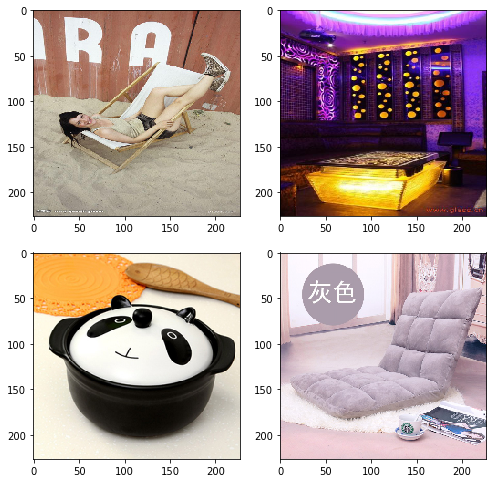

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
plt.subplot(2,2,1)
imshow(imgs[0])
plt.subplot(2,2,2)
imshow(imgs[-1])
plt.subplot(2,2,3)
imshow(imgs[20])
plt.subplot(2,2,4)
imshow(imgs[80])

# My Alexnet

In [6]:
inputs = Input((227, 227, 3))
c1 = Conv2D(96, 11, strides=(4, 4), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
m1 = MaxPooling2D((3, 3))(c1)

c2 = Conv2D(256, 5, strides=(1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(m1)
m2 = MaxPooling2D((3, 3))(c2)

c3 = Conv2D(384, 3, strides=(1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(m2)

c4 = Conv2D(384, 3, strides=(1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

c5 = Conv2D(256, 3, strides=(2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

m5 = MaxPooling2D((3, 3), strides=(2, 2))(c5)

d5 = Dropout(0.5) (m5)

fc6 = Dense(activation='relu', units=10)(d5)

fc7 = Dense(activation='relu', units=10)(fc6)

fc8 = Dense(activation='relu', units=128)(fc7)

output = Flatten()(fc8)

model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam', loss=tf.losses.softmax_cross_entropy, metrics=[metrics.categorical_accuracy])
model.summary()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 227, 227, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)  

# Train Models

In [7]:
tic = time.time()
model_name = 'model' 
model_name = model_name + '.h5'
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
results = model.fit(np.array(imgs),
                    pd.get_dummies(imgs_labels), 
                    validation_split=0.1, 
                    batch_size=16,
                    epochs=50, 
                    callbacks=[earlystopper, checkpointer])



toc = time.time() - tic
print('Training time...', toc/60)

Train on 576 samples, validate on 64 samples
Epoch 1/50
576/576 [==============================] - 9s 16ms/step - loss: 4.8617 - categorical_accuracy: 0.0069 - val_loss: 4.8608 - val_categorical_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 4.86080, saving model to model.h5
Epoch 2/50
576/576 [==============================] - 2s 4ms/step - loss: 4.8526 - categorical_accuracy: 0.0087 - val_loss: 4.8529 - val_categorical_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 4.86080 to 4.85291, saving model to model.h5
Epoch 3/50
576/576 [==============================] - 2s 4ms/step - loss: 4.8521 - categorical_accuracy: 0.0052 - val_loss: 4.8588 - val_categorical_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve
Epoch 4/50
576/576 [==============================] - 2s 4ms/step - loss: 4.8533 - categorical_accuracy: 0.0017 - val_loss: 4.8564 - val_categorical_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve
Epoch 5/50
576/576 [================

# Predict

In [16]:
path = '../test'
test_imgs_files = os.listdir(path)

chunks = np.arange(0 , len(test_imgs), 500)

In [37]:
results = []
for i, chunk in tqdm_notebook(enumerate(chunks), total=len(chunks)):
    if i < len(chunks) - 1:
        for test_imgs_file in tqdm_notebook(test_imgs_files[chunks[i]:chunks[i+1]], 
                                            total=len(test_imgs_files[chunks[i]:chunks[i+1]])):
            img = [(resize(imread(os.path.join(path, test_imgs_file)), (227, 227, 3)))]
            results.append(np.argmax(model.predict(np.array(img))))
    else:
         for test_imgs_file in tqdm_notebook(test_imgs_files[chunks[i]:len(test_imgs_files)], 
                                            total=len(test_imgs_files[chunks[i]:chunks[i+1]])):
            img = [(resize(imread(os.path.join(path, test_imgs_file)), (227, 227, 3)))]
            results.append(np.argmax(model.predict(np.array(img))))

HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

/home/omri/my_gpu/.env/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

# Submission File

In [49]:
submission = pd.DataFrame({'id':[int(x.split('.')[0]) for x in test_imgs_files],
                          'predicted': results}).sort_values(by='id')
submission_filename = 'sub.csv'
submission.to_csv(submission_filename)